# Mammalian Enhancer Classification with Genomic Pretraining and Fine Tuning 4-mer stride 2 Model

This notebook uses the enhancer dataset to fine tune the mammalian language model and train a classification model via transfer learning. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Promoter%20Classification%20Short%20Sequences/Human%20Promoters%20Short%20Sequences%203%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

To replicate a portion of the paper, the model will be trained on enhancer sequences from Human, Mouse, Dog and Opossum genomes. The multi-species model will then be used to predict on individual species.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import roc_auc_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

# Human

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
classification_df = classification_df[classification_df.Organism == 'Human']

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Human'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [11]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [12]:
len(model_vocab.itos)

1025

In [13]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [14]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [15]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [18]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [19]:
learn = get_model_LM(data, drop_mult, config)

In [20]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal1');

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


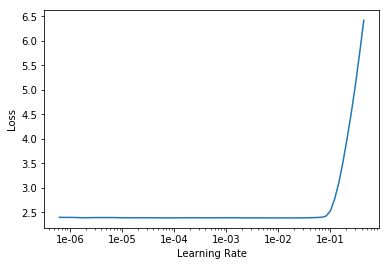

In [23]:
learn.recorder.plot()

# Training


In [24]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.381873,2.359686,0.247534,01:04
1,2.385333,2.360745,0.247125,01:04
2,2.381673,2.362020,0.247008,01:03
3,2.373429,2.362299,0.246711,01:03
4,2.362757,2.363557,0.246322,01:03
5,2.356408,2.363970,0.246520,01:03
6,2.350893,2.364205,0.246385,01:03
7,2.348211,2.364430,0.246378,01:03


In [26]:
learn.save('enhancer_human_LM_5m2s')
learn.save_encoder('enhancer_human_LM_5m2s_enc')

# Classification

In [14]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [15]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(1025, 1025)

In [18]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [19]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [20]:
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [22]:
learn.load_encoder('enhancer_human_LM_5m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


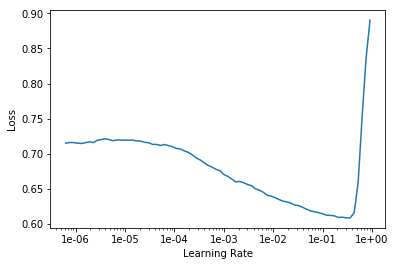

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.548524,0.552568,0.727857,00:37
1,0.535788,0.530162,0.738571,00:37
2,0.527499,0.529210,0.736429,00:37


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.527079,0.527215,0.738571,00:45
1,0.510017,0.516705,0.746429,00:45
2,0.492226,0.528799,0.743929,00:45


In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.485402,0.525098,0.745000,01:06
1,0.475794,0.525432,0.744643,01:06
2,0.450760,0.535396,0.738929,01:06


In [27]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.439763,0.542807,0.740714,01:23
1,0.434087,0.544682,0.740714,01:23
2,0.425413,0.545752,0.736786,01:23


In [28]:
learn.save('enhancer_human_clas_finetune_5m2s')

In [21]:
learn.load('enhancer_human_clas_finetune_5m2s');

In [29]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [30]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [31]:
roc_auc_score(y, preds[0][:,1])

0.8128818877551021

In [32]:
get_scores(learn)

Accuracy: 0.7257142857142858
False Positives: 0.1467857142857143
False Negatives: 0.1275
Recall: 0.745
Precision: 0.717331499312242
Specificity: 0.7064285714285714
MCC: 0.45176475417348344


# Mouse

In [7]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [8]:
classification_df = classification_df[classification_df.Organism == 'Mouse']

In [9]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [10]:
classification_df.Organism.unique()

array(['Mouse'], dtype=object)

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [12]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [13]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal1');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


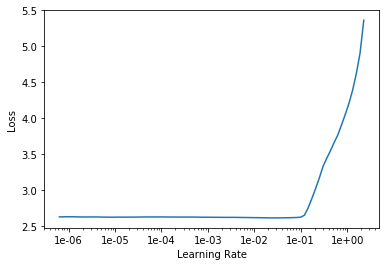

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.594401,2.559221,0.170276,01:02
1,2.544380,2.499074,0.193839,01:03
2,2.499727,2.471166,0.203807,01:03
3,2.464488,2.460768,0.208227,01:03
4,2.439468,2.454001,0.210769,01:03
5,2.422151,2.451507,0.212006,01:03
6,2.405539,2.450577,0.212371,01:04
7,2.396172,2.451107,0.212493,01:05


In [23]:
learn.save('enhancer_mouse_LM_5m2s')
learn.save_encoder('enhancer_mouse_LM_5m2s_enc')

# Classification

In [14]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [15]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(1025, 1025)

In [18]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.55

In [19]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [20]:
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.load_encoder('enhancer_mouse_LM_5m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


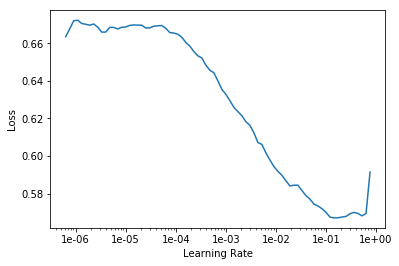

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.489805,0.552183,0.763929,00:37
1,0.481400,0.512567,0.761429,00:37
2,0.470673,0.472210,0.777857,00:37


In [24]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.466910,0.472438,0.775357,00:45
1,0.453001,0.456087,0.783214,00:45
2,0.435995,0.458659,0.781429,00:45


In [25]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.431951,0.454428,0.778929,01:06
1,0.423651,0.454873,0.785000,01:06
2,0.407900,0.455540,0.787857,01:06


In [26]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.398505,0.458987,0.787500,01:23
1,0.397066,0.461442,0.788571,01:23
2,0.390463,0.460818,0.789286,01:23


In [27]:
learn.save('enhancer_mouse_clas_finetune_5m2s')

In [19]:
learn.load('enhancer_mouse_clas_finetune_5m2s');

In [28]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [29]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [30]:
roc_auc_score(y, preds[0][:,1])

0.8712854591836735

In [31]:
get_scores(learn)

Accuracy: 0.7921428571428571
False Positives: 0.095
False Negatives: 0.11285714285714285
Recall: 0.7742857142857142
Precision: 0.802962962962963
Specificity: 0.81
MCC: 0.584658702331544


# Dog

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Dog']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Dog'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal1');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


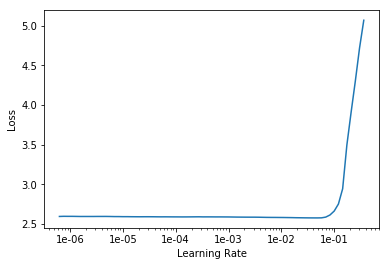

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.566746,2.524999,0.189996,01:03
1,2.521416,2.491432,0.201438,01:03
2,2.493346,2.481581,0.204522,01:03
3,2.477357,2.476596,0.206655,01:04
4,2.460354,2.474500,0.207563,01:04
5,2.446908,2.474747,0.207871,01:04
6,2.435672,2.474834,0.207916,01:04
7,2.430311,2.475110,0.207884,01:04


In [23]:
learn.save('enhancer_dog_LM_5m2s')
learn.save_encoder('enhancer_dog_LM_5m2s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(1025, 1025)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.45

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [19]:
learn.load_encoder('enhancer_dog_LM_5m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


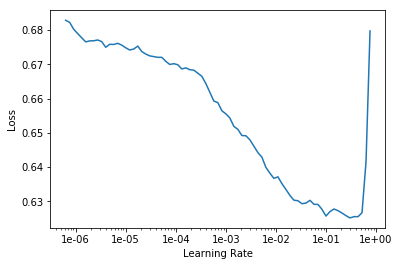

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.593089,0.579392,0.697857,00:37
1,0.576405,0.558730,0.714643,00:37
2,0.569057,0.558479,0.720714,00:38


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.567329,0.553638,0.723214,00:45
1,0.559965,0.546106,0.730357,00:45
2,0.535708,0.551042,0.726071,00:46


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524138,0.565998,0.719643,01:07
1,0.514574,0.551644,0.724286,01:07
2,0.487802,0.563997,0.723929,01:07


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.474843,0.569976,0.723571,01:23
1,0.459833,0.570368,0.725000,01:23
2,0.452522,0.576368,0.717143,01:23


In [25]:
learn.save('enhancer_dog_clas_finetune_5m2s')

In [19]:
learn.load('enhancer_dog_clas_finetune_5m2s');

In [26]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [27]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [28]:
roc_auc_score(y, preds[0][:,1])

0.7737729591836735

In [29]:
get_scores(learn)

Accuracy: 0.7039285714285715
False Positives: 0.1492857142857143
False Negatives: 0.1467857142857143
Recall: 0.7064285714285714
Precision: 0.7029140014214641
Specificity: 0.7014285714285714
MCC: 0.4078622411670221


# Opossum

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Opossum']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Opossum'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal1');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


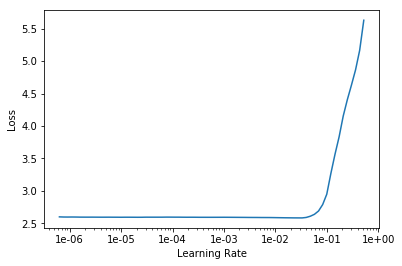

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.583936,2.567322,0.169077,01:03
1,2.553552,2.528700,0.182915,01:03
2,2.516097,2.503516,0.193041,01:03
3,2.486417,2.489861,0.198090,01:04
4,2.468625,2.482800,0.200838,01:04
5,2.458802,2.479201,0.202234,01:04
6,2.450018,2.477733,0.202835,01:04
7,2.446091,2.477559,0.202971,01:04


In [23]:
learn.save('enhancer_opossum_LM_5m2s')
learn.save_encoder('enhancer_opossum_LM_5m2s_enc')

# Classification

In [13]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [14]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(1025, 1025)

In [17]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.55

In [18]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [19]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.load_encoder('enhancer_opossum_LM_5m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


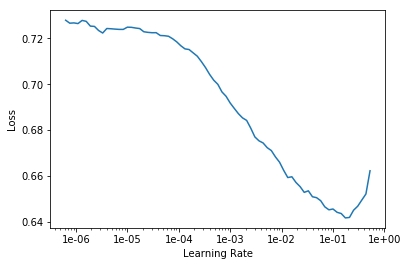

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.593078,0.590245,0.686429,00:37
1,0.575152,0.567360,0.708571,00:38
2,0.568341,0.574293,0.699286,00:38


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.565957,0.605808,0.682500,00:45
1,0.553154,0.573303,0.692143,00:45
2,0.530081,0.567603,0.713929,00:45


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524601,0.568532,0.705000,01:06
1,0.513965,0.568878,0.710357,01:06
2,0.486535,0.578683,0.717143,01:06


In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.471875,0.576033,0.717857,01:23
1,0.471426,0.580151,0.716786,01:23
2,0.464220,0.579957,0.717857,01:23


In [26]:
learn.save('enhancer_opossum_clas_finetune_5m2s')

In [27]:
learn.load('enhancer_opossum_clas_finetune_5m2s');

In [27]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [28]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [29]:
roc_auc_score(y, preds[0][:,1])

0.7872701530612245

In [30]:
get_scores(learn)

Accuracy: 0.7082142857142857
False Positives: 0.1375
False Negatives: 0.15428571428571428
Recall: 0.6914285714285714
Precision: 0.7154471544715447
Specificity: 0.725
MCC: 0.4166634359722151
